# QuestDB
This tutorial will show you how to get a QuestDB instance up and running locally to test JupySQL. You can run this in a Jupyter notebook.

## Pre-requisites

To run this tutorial, you need to install following Python packages:

In [30]:
%pip install jupysql pandas pyarrow --quiet

Note: you may need to restart the kernel to use updated packages.


You also need a PostgreSQL connector. We recommend using `psycopg2`. The easiest way to install it is via:

In [31]:
%pip install psycopg2-binary --quiet

Note: you may need to restart the kernel to use updated packages.


You also need Docker installed and running to start the QuestDB instance.

## Start QuestDB instance

We fetch the official image, create a new database, and user (this will take 1-2 minutes):

In [32]:
%%bash
docker run --detach --name questdb_ \
    -p 9000:9000 -p 9009:9009 -p 8812:8812 -p 9003:9003 questdb/questdb:7.1

0322c413699420adb1ccb136bc602d0a6514276df34778c90e60cf423ab8aac6


Our database is running, let's load some data!

## Load sample data

Now, let's fetch some sample data. We'll be using the [Penguins dataset](https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv):

In [33]:
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv",
    "penguins.csv",
)

('penguins.csv', <http.client.HTTPMessage at 0x2dda0ff3810>)

Let's create a new table `penguins` in our QuestDB instance and load this csv file into it (this will take about a minute)

In [34]:
import requests

with open("penguins.csv", "rb") as csv:
    file_data = csv.read()
    files = {"data": ("penguins", file_data)}
    response = requests.post("http://127.0.0.1:9000/imp", files=files)

## Query

Now, let's start JuppySQL, authenticate and start querying the data!

In [35]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Create a new connection using `psycopg2`

In [36]:
import psycopg2 as pg

engine = pg.connect(
    "dbname='qdb' user='admin' host='127.0.0.1' port='8812' password='quest'"
)

Initialize the connection

In [37]:
%sql engine

```{important}
If the cell above fails, you might have some missing packages. Message us on [Slack](https://ploomber.io/community) and we'll help you!
```

Let's run our first queries to count and fetch some data

In [38]:
%%sql
SELECT COUNT(*) FROM penguins

*  "<connection object at 0x000002DD9FE81CF0; dsn: 'user=admin password=xxx dbname=qdb host=127.0.0.1 port=8812', closed: 0>"
1 rows affected.


count
344


In [39]:
%sql select * from penguins limit 5

*  "<connection object at 0x000002DD9FE81CF0; dsn: 'user=admin password=xxx dbname=qdb host=127.0.0.1 port=8812', closed: 0>"
5 rows affected.


species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
Adelie,Torgersen,39.1,18.7,181,3750,MALE
Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
Adelie,Torgersen,None,None,None,None,None
Adelie,Torgersen,36.7,19.3,193,3450,FEMALE


## Plotting

To utilize JupySQL ggplot API, it is crucial to have valid data, so let's remove null values.

In [40]:
%%sql --save no_nulls --no-execute
SELECT *
FROM penguins
WHERE body_mass_g IS NOT NULL and
sex IS NOT NULL

*  "<connection object at 0x000002DD9FE81CF0; dsn: 'user=admin password=xxx dbname=qdb host=127.0.0.1 port=8812', closed: 0>"
Skipping execution...


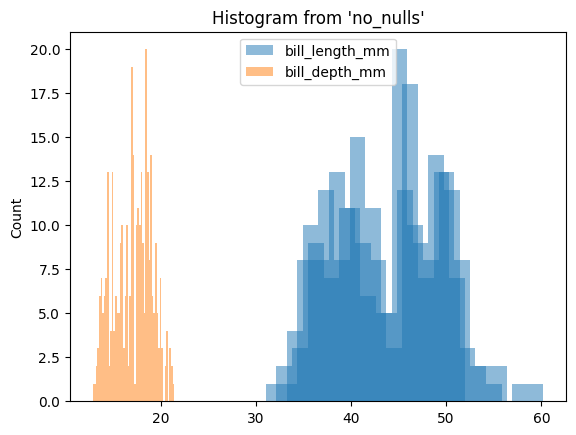

In [41]:
from sql.ggplot import ggplot, aes, geom_histogram

(
    ggplot(
        table="no_nulls",
        with_="no_nulls",
        mapping=aes(x=["bill_length_mm", "bill_depth_mm"]),
    )
    + geom_histogram(bins=50)
)

## Clean up

In [42]:
! docker container ls

CONTAINER ID   IMAGE                 COMMAND                  CREATED          STATUS         PORTS                                                                                            NAMES
0322c4136994   questdb/questdb:7.1   "/docker-entrypoint.…"   10 seconds ago   Up 9 seconds   0.0.0.0:8812->8812/tcp, 0.0.0.0:9000->9000/tcp, 0.0.0.0:9003->9003/tcp, 0.0.0.0:9009->9009/tcp   questdb_


In [43]:
%%capture out
! docker ps -a -q --filter="name=questdb" --quiet

In [44]:
container_id = out.stdout.strip()
print(f"Container id: {container_id}")

Container id: 0322c4136994


In [45]:
! docker container stop {container_id}

0322c4136994


In [46]:
! docker container rm {container_id}

0322c4136994


In [47]:
! docker container ls

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES
